In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tensorflow.keras import models, layers, callbacks, optimizers, regularizers
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import metrics
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [2]:
def Split(x, y, seed=0):
    a = int(0.8 * x.shape[0])
    b = int(0.9 * x.shape[0])
    index = np.arange(a)
    np.random.seed(seed)
    np.random.shuffle(index)
    return x[:a][index], y[:a][index], x[a:b], y[a:b], x[b:], y[b:]

In [3]:
class StandardScaler:
    def __init__(self, data):
        self.mean = np.mean(data)
        self.std = np.std(data)

    def transform(self, data):
        return (data - self.mean) / self.std

    def inverse_transform(self, data):
        return data * self.std + self.mean

In [4]:
df = pd.read_csv('bdi.csv', parse_dates=['date'], index_col=['date'])
df

,bdi
date,
2000-01-01,1319.0
2000-01-02,NaN
2000-01-03,NaN
2000-01-04,1320.0
2000-01-05,1329.0
...,...
2020-10-05,2071.0
2020-10-06,2097.0
2020-10-07,2044.0


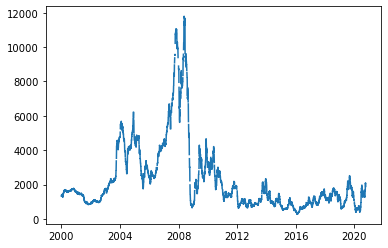

In [5]:
plt.plot(df)

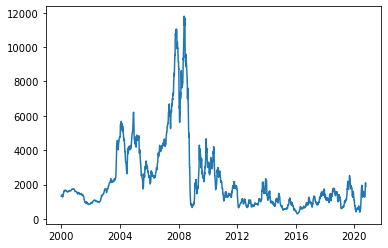

In [6]:
df.fillna(method='ffill', inplace=True)
plt.plot(df)

In [7]:
sample = df.values

In [8]:
label = [0]
for i in range(1, sample.shape[0]):
    if sample[i] > sample[i-1]:
        label.append(1)
    elif sample[i] < sample[i-1]:
        label.append(2)
    else:
        label.append(0)
label = np.array(label).reshape(-1, 1)

In [9]:
oe = preprocessing.OneHotEncoder()
label = oe.fit_transform(label).toarray()

In [10]:
label

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]])

In [11]:
y = np.array([label[i] for i in range(90, label.shape[0])])
x = np.array([sample[i-30:i] for i in range(30, sample.shape[0])]).reshape(-1,30,1)
x = np.array([x[i-61:i] for i in range(61, x.shape[0]+1)])

In [12]:
x_train, y_train, x_val, y_val, x_test, y_test = Split(x, y, seed=42)

In [13]:
scaler = StandardScaler(x_train.reshape(-1))
x_train = scaler.transform(x_train)
x_val = scaler.transform(x_val)
x_test = scaler.transform(x_test)

In [14]:
model = models.load_model('checkpoint.h5')
model.pop()
model.add(layers.Dropout(0.2, name='add_layer_0'))
model.add(layers.Dense(3, kernel_regularizer=regularizers.l2(), name='add_layer_1'))
model.add(layers.Softmax(name='add_layer_2'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 61, 30, 32)        160       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 61, 30, 32)        0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 61, 15, 32)        0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 61, 15, 32)        2080      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 61, 15, 32)        0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 61, 7, 32)         0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 61, 224)           0

In [15]:
filepath = 'checkpoint_crossentropy.h5'
checkpoint = callbacks.ModelCheckpoint(filepath=filepath, monitor='val_loss', save_best_only=True)
h0 = model.fit(x_train, y_train,batch_size=256, epochs=50, 
               validation_data=(x_val, y_val), callbacks=[checkpoint], shuffle=True)
model = models.load_model(filepath)

Epoch 1/50
24/24 [==============================] - 7s 275ms/step - loss: 1.2176 - accuracy: 0.3406 - val_loss: 1.1557 - val_accuracy: 0.4013
Epoch 2/50
24/24 [==============================] - 1s 35ms/step - loss: 1.1500 - accuracy: 0.3695 - val_loss: 1.1512 - val_accuracy: 0.3573
Epoch 3/50
24/24 [==============================] - 1s 33ms/step - loss: 1.1411 - accuracy: 0.3838 - val_loss: 1.1503 - val_accuracy: 0.3453
Epoch 4/50
24/24 [==============================] - 1s 34ms/step - loss: 1.1331 - accuracy: 0.3905 - val_loss: 1.1410 - val_accuracy: 0.3933
Epoch 5/50
24/24 [==============================] - 1s 34ms/step - loss: 1.1221 - accuracy: 0.4093 - val_loss: 1.1375 - val_accuracy: 0.3853
Epoch 6/50
24/24 [==============================] - 1s 32ms/step - loss: 1.1186 - accuracy: 0.3971 - val_loss: 1.1522 - val_accuracy: 0.3373
Epoch 7/50
24/24 [==============================] - 1s 32ms/step - loss: 1.1163 - accuracy: 0.3985 - val_loss: 1.1302 - val_accuracy: 0.3787
Epoch 8/50
2

In [16]:
model.compile(loss='categorical_crossentropy', 
              optimizer=optimizers.SGD(lr=0.001, momentum=0.9), metrics=['accuracy'])
h1 = model.fit(x_train, y_train,batch_size=256, epochs=30, 
               validation_data=(x_val, y_val), callbacks=[checkpoint], shuffle=True)
model = models.load_model(filepath)

Epoch 1/30
24/24 [==============================] - 1s 53ms/step - loss: 0.4351 - accuracy: 0.8469 - val_loss: 0.6308 - val_accuracy: 0.7413
Epoch 2/30
24/24 [==============================] - 1s 32ms/step - loss: 0.4280 - accuracy: 0.8528 - val_loss: 0.6379 - val_accuracy: 0.7360
Epoch 3/30
24/24 [==============================] - 1s 32ms/step - loss: 0.4313 - accuracy: 0.8486 - val_loss: 0.6440 - val_accuracy: 0.7253
Epoch 4/30
24/24 [==============================] - 1s 32ms/step - loss: 0.4270 - accuracy: 0.8538 - val_loss: 0.6437 - val_accuracy: 0.7293
Epoch 5/30
24/24 [==============================] - 1s 32ms/step - loss: 0.4262 - accuracy: 0.8528 - val_loss: 0.6472 - val_accuracy: 0.7307
Epoch 6/30
24/24 [==============================] - 1s 33ms/step - loss: 0.4244 - accuracy: 0.8548 - val_loss: 0.6396 - val_accuracy: 0.7400
Epoch 7/30
24/24 [==============================] - 1s 33ms/step - loss: 0.4275 - accuracy: 0.8523 - val_loss: 0.6444 - val_accuracy: 0.7373
Epoch 8/30
24

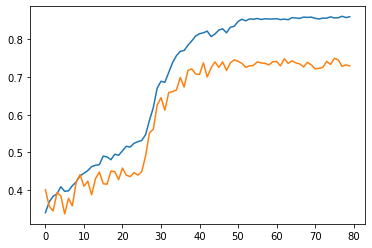

In [17]:
plt.plot(h0.history['accuracy'] + h1.history['accuracy'])
plt.plot(h0.history['val_accuracy'] + h1.history['val_accuracy'])

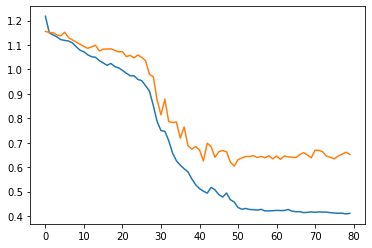

In [18]:
plt.plot(h0.history['loss'] + h1.history['loss'])
plt.plot(h0.history['val_loss'] + h1.history['val_loss'])

In [19]:
predict = model.predict(x_test)
y_test = np.argmax(y_test, axis=1)
predict = np.argmax(predict, axis=1)
metrics.accuracy_score(y_test, predict)

0.6933333333333334

In [37]:
train = model.predict(x_train)
train = np.argmax(train, axis=1).reshape(-1, 1)
train = oe.fit_transform(train).toarray()
train = pd.DataFrame(columns=['0', '1', '2'], data=train)
train.to_csv('train.csv', index=False, header=True)
train

,0,1,2
0,0.0,1.0,0.0
1,1.0,0.0,0.0
2,0.0,1.0,0.0
3,0.0,0.0,1.0
4,1.0,0.0,0.0
...,...,...,...
5993,0.0,1.0,0.0
5994,0.0,0.0,1.0
5995,0.0,0.0,1.0
5996,0.0,1.0,0.0


In [38]:
val = model.predict(x_val)
val = np.argmax(val, axis=1).reshape(-1, 1)
val = oe.fit_transform(val).toarray()
val = pd.DataFrame(columns=['0', '1', '2'], data=val)
val.to_csv('val.csv', index=False, header=True)
val

,0,1,2
0,0.0,0.0,1.0
1,0.0,0.0,1.0
2,1.0,0.0,0.0
3,1.0,0.0,0.0
4,0.0,1.0,0.0
...,...,...,...
745,1.0,0.0,0.0
746,0.0,0.0,1.0
747,0.0,0.0,1.0
748,0.0,1.0,0.0


In [39]:
test = model.predict(x_test)
test = np.argmax(test, axis=1).reshape(-1, 1)
test = oe.fit_transform(test).toarray()
test = pd.DataFrame(columns=['0', '1', '2'], data=test)
test.to_csv('test.csv', index=False, header=True)
test

,0,1,2
0,1.0,0.0,0.0
1,1.0,0.0,0.0
2,1.0,0.0,0.0
3,0.0,1.0,0.0
4,0.0,1.0,0.0
...,...,...,...
745,1.0,0.0,0.0
746,0.0,1.0,0.0
747,0.0,1.0,0.0
748,0.0,1.0,0.0
